Dataset size: (96, 9)


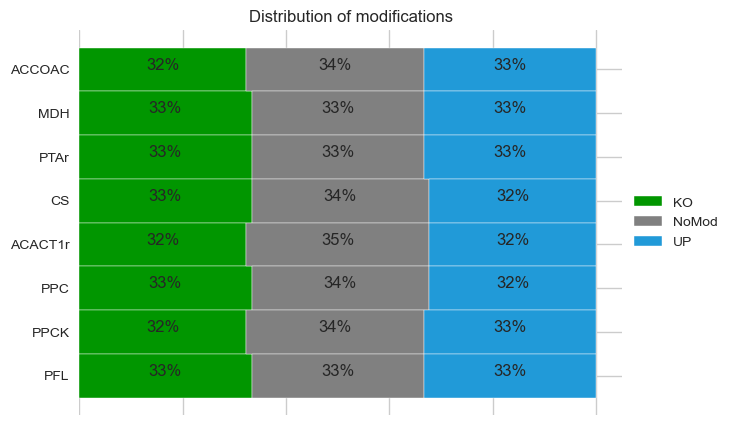

In [5]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

from src import plot_multiomics
from straindesignxai.main import DataLoader

file_path = "../data/EDD_isoprenol_production.csv"
model_path = "../models/xgb_isoprenol.pkl"

input_var = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
response_var = ["Value"]

d = DataLoader(file_path, input_var, response_var)
plot_multiomics.plot_distribution_of_designs(d.df.drop("Value", axis=1))

In [6]:
# How many designs improve production over the WT
print(
    len(d.df[d.df["Value"] > d.df.loc["WT"]["Value"]]),
    "designs out of",
    len(d.df),
    "improve production over the WT",
)

11 designs out of 96 improve production over the WT


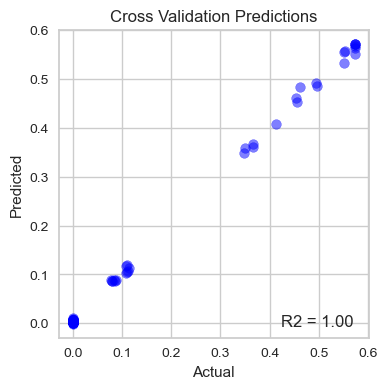

In [7]:
# load or train ml model
try:
    d.load_model(model_path)
except FileNotFoundError:
    d.train_xgb(n_iter=500)
    d.save_model(model_path)

d.plot_R2()

In [8]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
result = permutation_importance(d.model, d.X, d.y, n_repeats=10, random_state=0)

# Get the feature importances
importances = result.importances_mean

# Print the feature importances
for feature, importance in zip(d.X.columns, importances):
    print(f"{feature}: {importance}")


ACCOAC: 0.7234190941808046
MDH: 0.04895112972020325
PTAr: 0.008692201968989621
CS: 0.9042116002657001
ACACT1r: 0.7405018221719398
PPC: 0.519723122209738
PPCK: 0.0007705955125345554
PFL: 0.0004925289530546939


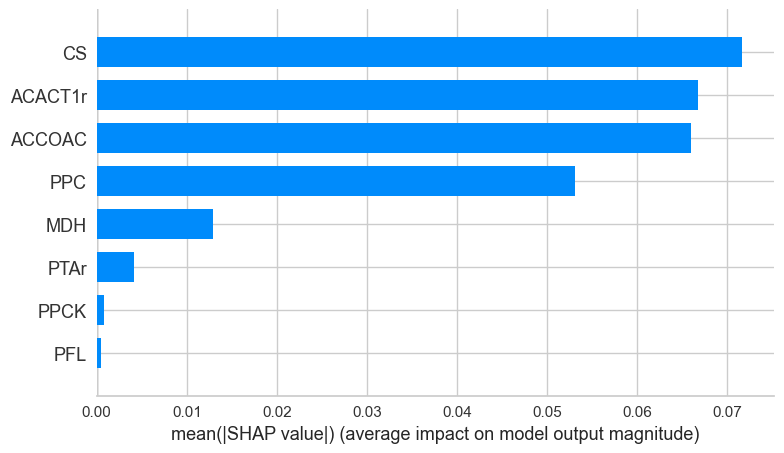

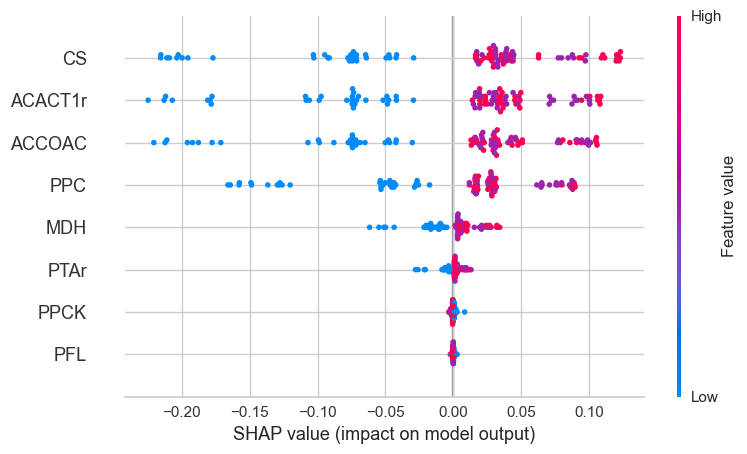

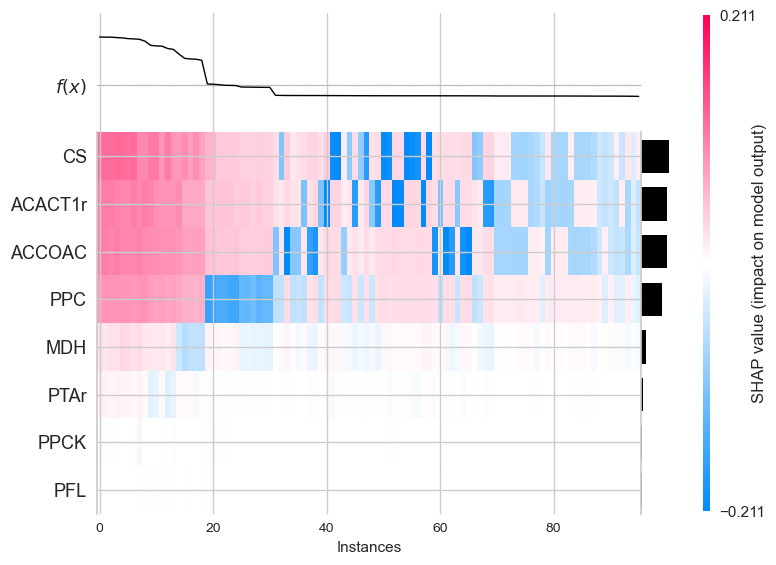

In [9]:
d.get_shap_values()

### Sort columns of `shap_df` by absolute `mean`/`man` shap values

In [10]:
# Sort columns of d.shap_df by mean absolute shap value
d.shap_df = d.shap_df.reindex(
    np.abs(d.shap_df).mean().sort_values(ascending=False).index, axis=1
)
np.abs(d.shap_df).describe().loc["max"]

CS         0.215608
ACACT1r    0.224800
ACCOAC     0.220575
PPC        0.166008
MDH        0.061654
PTAr       0.027843
PPCK       0.008366
PFL        0.002814
Name: max, dtype: float64

### Supervised clustering

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

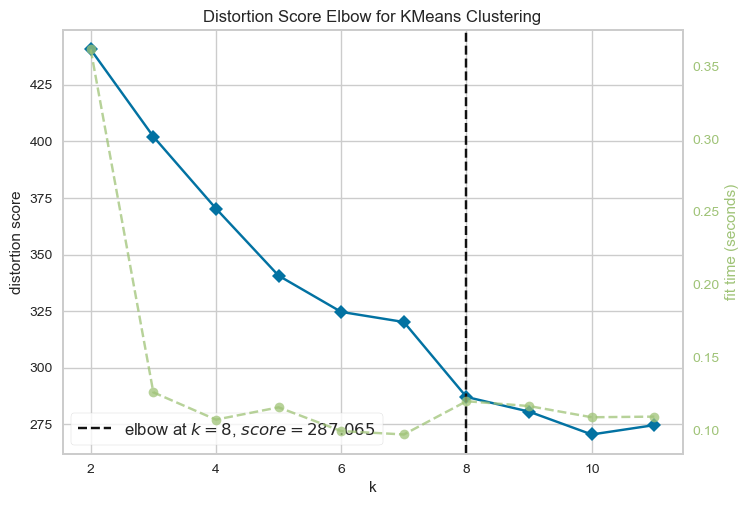

Optimal number of clusters: 8


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


In [11]:
d.supervised_clustering()

In [12]:
d.df["pred"] = d.model.predict(d.df.drop(["Value", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    d.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)
d.df[d.df["cluster"] == top_cluster]

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value,cluster,pred
Line Name,,,,,,,,,,,
Strain 2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.552101,6,0.554696
Strain 4,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.551849,6,0.533084
Strain 7,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.572648,6,0.571667
Strain 17,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.495097,6,0.492459
Strain 41,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.572648,6,0.564361
Strain 46,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.572648,6,0.572483
Strain 48,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.572648,6,0.567612
Strain 49,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.572648,6,0.571661
Strain 53,2.0,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.456256,6,0.453333


### Partial Dependence and Scatter Plots

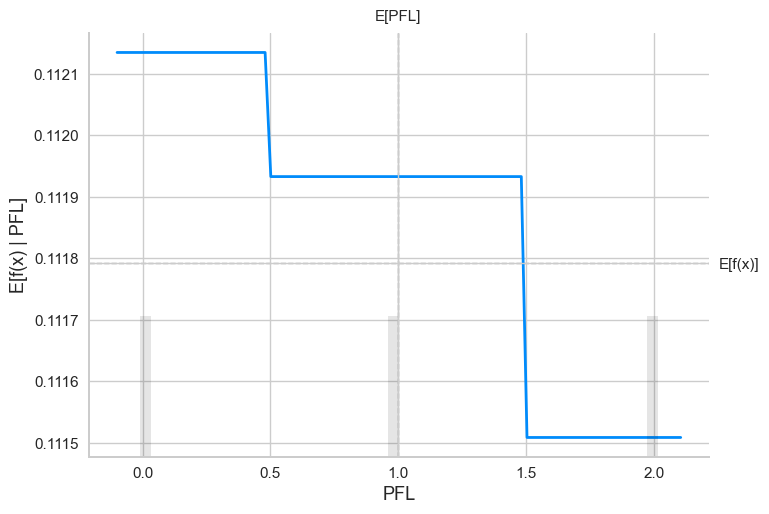

In [13]:
d.pdplot("PFL")

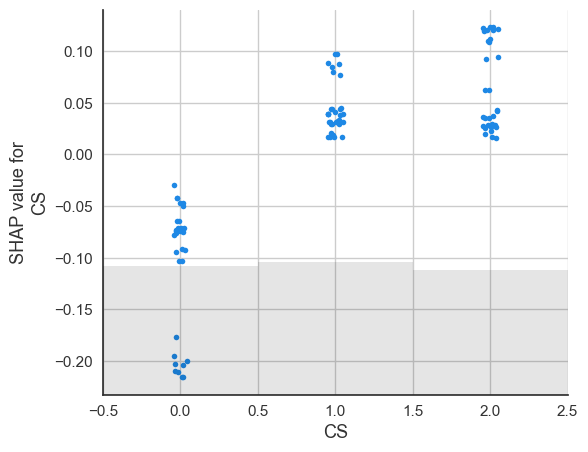

In [14]:
d.shap_scatter("CS")

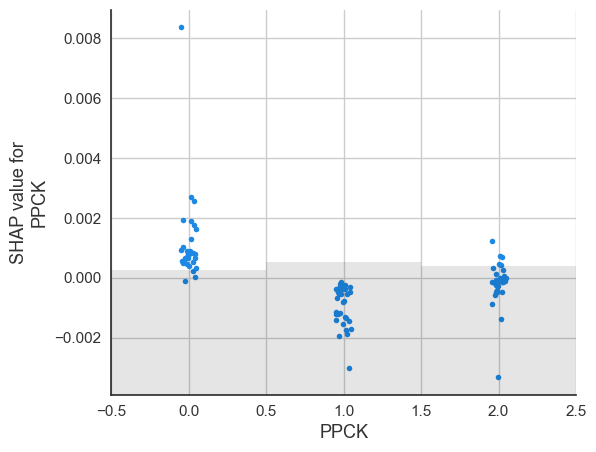

In [15]:
d.shap_scatter("PPCK")

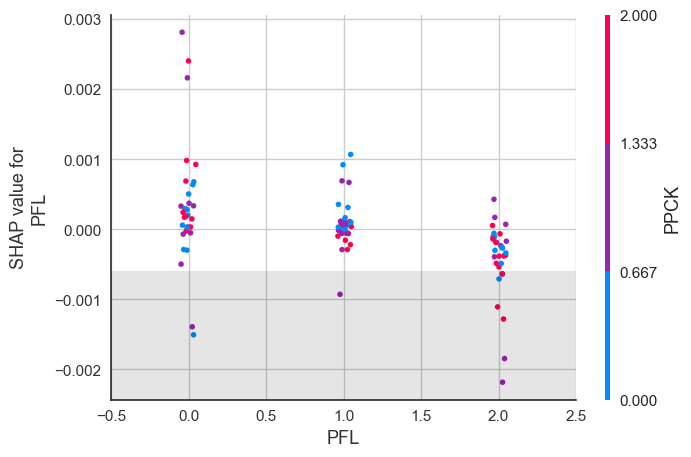

In [16]:
d.shap_scatter("PFL", "PPCK")

### Sampling

In [17]:
d.shap_df[d.shap_df["cluster"] == top_cluster]

,CS,ACACT1r,ACCOAC,PPC,MDH,PTAr,PPCK,PFL,cluster,Value
1,0.120350,0.106185,0.100437,0.085606,0.024727,0.008219,-0.001228,-0.001391,6,0.552101
3,0.097680,0.106512,0.097136,0.089756,0.020903,0.008044,-0.001552,0.002814,6,0.551849
6,0.120620,0.108635,0.105503,0.089387,0.022048,0.012534,0.001635,-0.000487,6,0.572648
16,0.110206,0.100570,0.094482,0.080033,0.021103,-0.025922,0.000903,-0.000708,6,0.495097
40,0.123180,0.100355,0.099731,0.086268,0.034206,0.009572,-0.001173,0.000429,6,0.572648
45,0.123044,0.107657,0.105912,0.087793,0.026719,0.010760,-0.001887,0.000692,6,0.572648
47,0.122194,0.100562,0.105505,0.089000,0.026154,0.013048,-0.001314,0.000670,6,0.572648
48,0.121544,0.108102,0.101107,0.087954,0.027859,0.009536,0.002697,0.001069,6,0.572648
52,0.087707,0.087446,0.090947,0.075879,0.024321,-0.021279,-0.003323,-0.000156,6,0.456256
61,0.119997,0.100176,0.098921,0.086527,0.032028,0.008975,0.000504,-0.001505,6,0.552734


In [18]:
clstr_df = d.study_clusters("most_frequent", verbose=False)
clstr_df.sort_values("pred", ascending=False, inplace=True)
clstr_df = clstr_df.head(1)

bounds = pd.DataFrame(index=d.X.columns, columns=["lower", "upper"])
# bounds.loc['CS'] = [0, 2]
for col in d.X.columns:
    l_b = clstr_df[col].values[0] - 1
    u_b = clstr_df[col].values[0]
    bounds.loc[col] = [l_b, u_b]

# Gerate samples from a Latin hypercube generator
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=d.X.shape[1])
sample = sampler.random(100000)
LB = bounds["lower"].values.tolist()
UB = bounds["upper"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=d.X.columns)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = d.model.predict(sample_df)
# Drop duplicates
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False)

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
262,1,2,1,2,1,1,0,1,0.570705
379,1,2,1,2,1,1,1,1,0.562735
123,1,2,1,2,1,1,0,0,0.562565
182,1,2,1,2,1,1,1,0,0.557051
200,1,1,1,2,1,1,0,1,0.554392
...,...,...,...,...,...,...,...,...,...
825,0,1,1,2,0,0,1,1,-0.000839
124,0,1,1,2,0,0,0,1,-0.000839
351,0,1,1,2,0,0,0,0,-0.000839
111,0,1,0,2,0,0,1,0,-0.001067


In [19]:
bounds

,lower,upper
ACCOAC,0.0,1.0
MDH,1.0,2.0
PTAr,0.0,1.0
CS,1.0,2.0
ACACT1r,0.0,1.0
PPC,0.0,1.0
PPCK,0.0,1.0
PFL,0.0,1.0


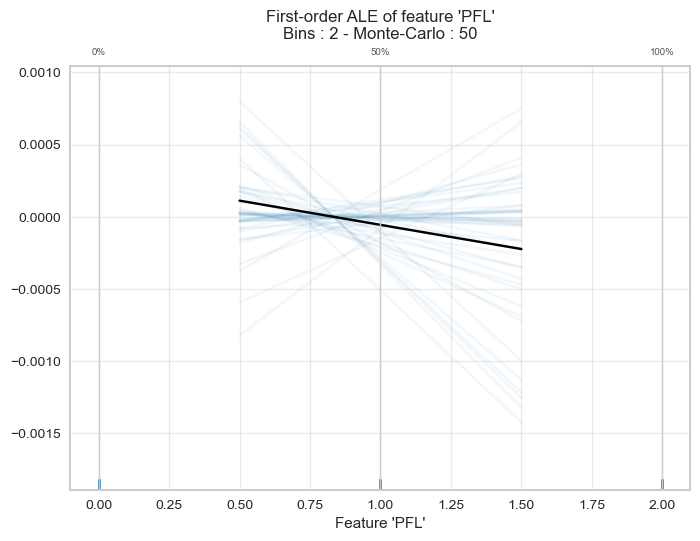

<Axes: title={'center': "First-order ALE of feature 'PFL'\nBins : 2 - Monte-Carlo : 50"}, xlabel="Feature 'PFL'">

In [20]:
from alepython import ale_plot

ale_plot(d.model, d.X, "PFL", monte_carlo=True)

## MCMC

In [21]:
def model_predict(X):
    # EX. np.array([1., 2., 2., 0., 2., 2., 0., 2.]).
    return d.model.predict(X.reshape(1, -1))

s_df = d.df[d.df["cluster"] == top_cluster]
s_df.head()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value,cluster,pred
Line Name,,,,,,,,,,,
Strain 2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.552101,6,0.554696
Strain 4,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.551849,6,0.533084
Strain 7,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.572648,6,0.571667
Strain 17,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.495097,6,0.492459
Strain 41,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.572648,6,0.564361


In [22]:
clstr_df = d.study_clusters("most_frequent", verbose=False)
clstr_df.sort_values("pred", ascending=False, inplace=True)
clstr_df = clstr_df.head(1)

bounds = pd.DataFrame(index=d.X.columns, columns=["lower", "upper"])
# bounds.loc['CS'] = [0, 2]
for col in d.X.columns:
    l_b = clstr_df[col].values[0] - 1
    u_b = clstr_df[col].values[0]
    bounds.loc[col] = [l_b, u_b]

# Gerate samples from a Latin hypercube generator
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=d.X.shape[1])
sample = sampler.random(100000)
LB = bounds["lower"].values.tolist()
UB = bounds["upper"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=d.X.columns)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = d.model.predict(sample_df)
# Drop duplicates
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False)

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
269,1,2,1,2,1,1,0,1,0.570705
60,1,2,1,2,1,1,1,1,0.562735
284,1,2,1,2,1,1,0,0,0.562565
77,1,2,1,2,1,1,1,0,0.557051
967,1,1,1,2,1,1,0,1,0.554392
...,...,...,...,...,...,...,...,...,...
476,0,1,1,2,0,0,0,1,-0.000839
69,0,1,1,2,0,0,1,0,-0.000839
673,0,1,1,2,0,0,1,1,-0.000839
216,0,1,0,2,0,0,1,0,-0.001067


In [33]:
s_df['Value'].describe()

count    14.000000
mean      0.532511
std       0.048575
min       0.452918
25%       0.495429
50%       0.552417
75%       0.572648
max       0.572648
Name: Value, dtype: float64

0.56273496

In [105]:
import pymc as pm

observations = s_df['Value'].values
mf_df = pd.DataFrame(d.study_clusters("most_frequent", verbose=False).iloc[top_cluster]).T
mf_df.drop(['Value', 'pred'], axis=1, inplace=True)

# Ensure that the observed data shape matches the shape of mu
n_obs = len(observations)

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    cs = pm.DiscreteUniform('cs', lower=1, upper=2)
    # Expected Value of outcome
    mu = d.model.predict(mf_df).flatten()
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=0.1, observed=observations)

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, cores=4)  # Adjust 'tune' and 'cores' based on your needs

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [cs]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 20 seconds.


The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


<Figure size 700x700 with 0 Axes>

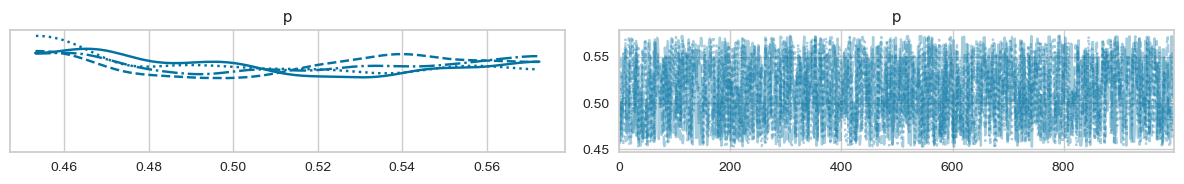

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
pm.plot_trace(trace)
pm.summary(trace).round(2)
plt.tight_layout()
plt.show()

In [43]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    p        (chain, draw) float64 0.4977 0.4977 0.4977 ... 0.5268 0.4657 0.4621
Attributes:
    created_at:                 2024-01-23T14:01:30.481566
    arviz_version:              0.16.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              23.82118821144104
    tuning_steps:               1000

In [45]:
pd.DataFrame(trace.posterior.get('p').values).T[3]

0      0.500497
1      0.500497
2      0.480157
3      0.467223
4      0.477133
         ...   
995    0.472766
996    0.481168
997    0.526793
998    0.465668
999    0.462117
Name: 3, Length: 1000, dtype: float64

In [ ]:
1/0

In [ ]:
import pymc as pm



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
c:\Users\mexis\anaconda3\envs\main\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


KeyError: 'mu'